![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Se complementa con algunas metricas adicionales para la variable "total" por cada estación
bikes.groupby('season')['total'].agg(
    mean='mean',
    min='min',
    p25=lambda x: x.quantile(0.25),
    median='median',
    p75=lambda x: x.quantile(0.75),
    max='max'
    )

,mean,min,p25,median,p75,max
season,,,,,,
1,116.343261,1,24.0,78.0,164.0,801
2,215.251372,1,49.0,172.0,321.0,873
3,234.417124,1,68.0,195.0,347.0,977
4,198.988296,1,51.0,161.0,294.0,948


Respecto a los datos/metricas de la variable `total` agrupada por la variable `season` se puede observar que:
* Según el diccionario de datos los valores en la variable correspondes a 1:winter, 2:spring, 3:summer, 4:fall
* La media del total de bicicletas rentadas por hora es significativamente menor en invierno que en el resto de estaciones, por otra parte el promedio es mas alto en verano.
* En las 4 estaciones la media es mayor que la mediana lo que posiblemente indica la presencia de datos con valores muy altos 'outliers' o una distribucion de datos sesgada a la izquierda.
* El valor asumido por la variable `season` parece tener influencia en la varibale de respuesta `total`

In [6]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [7]:
# Se complementa con algunas metricas adicionales para la variable "total" por cada hora
bikes.groupby('hour')['total'].agg(
    mean='mean',
    min='min',
    p25=lambda x: x.quantile(0.25),
    median='median',
    p75=lambda x: x.quantile(0.75),
    max='max'
    )

,mean,min,p25,median,p75,max
hour,,,,,,
0,55.138462,2,24.00,41.0,74.50,283
1,33.859031,1,11.00,19.0,46.00,168
2,22.899554,1,5.00,11.0,32.00,119
3,11.757506,1,3.00,6.0,15.00,66
4,6.407240,1,3.00,6.0,9.00,28
5,19.767699,1,8.00,19.0,29.00,57
6,76.259341,1,24.50,75.0,118.00,213
7,213.116484,1,63.00,208.0,334.00,596
8,362.769231,8,133.50,392.0,563.50,839


Respecto a los datos/metricas de la variable `total` agrupada por la variable `hour` se puede observar que:
* Basados en el comportamiento de la media a lo largo del dia, el periodo de mayor actividad se da entre las 7AM y las 9PM.
* El promedio mas alto se encuentra a las 5PM
* La media es mas alta que la mediana en la mayoria de horas, las unicas excepciones son 8AM y las 5PM.
* La variable `hour` parece ser una buena candidata para predecir la variable `total`

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

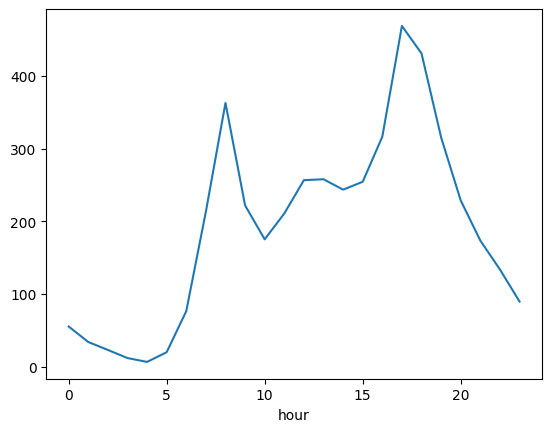

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

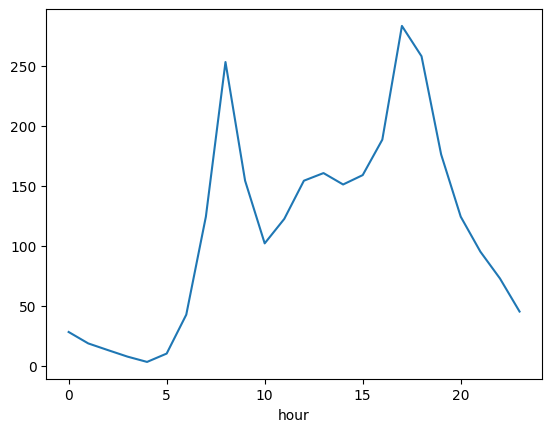

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
invierno = bikes[bikes['season'] == 1]
invierno.groupby('hour').total.mean().plot()

En el anterior grafico se observa el numero promedio de bicicletas rentadas por hora cuando la estación corresponde a invierno. Se puede observar que:
* En general la disposicion de los valores sigue la misma forma que el grafico anterior en el que se mostraba el numero promedio de bicicletas rentadas por hora en todo el set de datos.
* El rango de horas con mayor actividad de rentas se da entre las 8AM y las 5PM.
* Hay 2 picos muy marcados en 8AM y 5PM, lo cual coincide en general con los horarios de entrada y salida de oficinas, instituciones educativas, etc.
* Si bien la forma del grafico es similar al grafico general mostrado al inicio de esta sección, se debe notar que los valores son mucho mas bajos.

<Axes: xlabel='hour'>

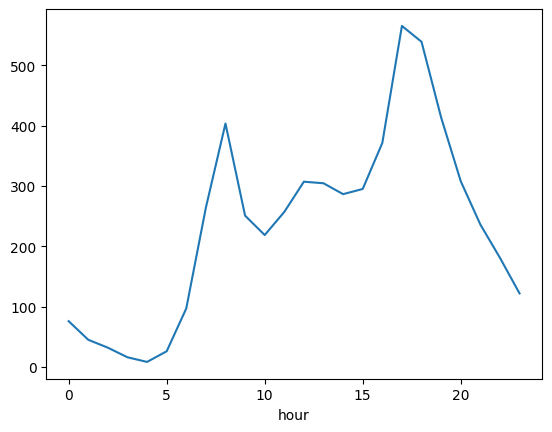

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
verano = bikes[bikes['season'] == 3]
verano.groupby('hour').total.mean().plot()

En el anterior grafico se observa el numero promedio de bicicletas rentadas por hora cuando la estación corresponde a verano. Se puede observar que:
* En general la disposición de los valores sigue la misma forma que el primer gráfico en el que se mostraba el numero promedio de bicicletas rentadas por hora en todo el set de datos.
* El rango de horas con mayor actividad de rentas se da entre las 8AM y las 5PM.
* Hay 2 picos muy marcados en 8AM y 5PM, lo cual coincide en general con los horarios de entrada y salida de oficinas, instituciones educativas, etc.
* La forma del grafico sigue muy de cerca la forma del grafico al inicio de la sección, sin embargo ha de notarse que en este caso los valores son ligeramente mas altos.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a un conjunto de train de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [49]:
# Celda 3
# Se definen las columnas para el modelo de regresion lineal
train = bikes[['total', 'season', 'hour']]
train = pd.get_dummies(train, columns=['season'], drop_first=True).astype(int)
train.reset_index(drop=True, inplace=True)

# Se definen las variables dependientes "X" e independiente "y"
X = train.drop(columns='total')
y = train['total']
print("Las variables predictoras son: ", X.columns)
print("La variable dependiente es: ", y.name)

# Se dividen los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Se entrena el modelo de regresion lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Se imprimen los coeficientes del modelo
print("El intercepto del modelo es: ", modelo.intercept_)
print("Los coeficientes del modelo son: ", modelo.coef_)

# Se generan las predicciones para el conjunto de prueba
y_pred = modelo.predict(X_test)

# Se evalua el modelo con el conjunto de prueba
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE: ", mse)
print("R^2: ", r2)

Las variables predictoras son:  Index(['hour', 'season_2', 'season_3', 'season_4'], dtype='object')
La variable dependiente es:  total
El intercepto del modelo es:  -7.671323432608176
Los coeficientes del modelo son:  [ 10.6876776   99.03019821 115.71036692  90.63770541]
MSE:  25366.611967658602
R^2:  0.21636575170625916


**Interpretación de los coeficientes del modelo**
* Coeficiente de la variable `hour` (10.68) --> Indica que el numero de bicicletas rentadas aumenta en 10.68 en cada aumento unitario de la variable `hour`
* Coeficiente de la variable `season_2` (99.03) --> Indica que el numero de bicicletas rentadas aumenta en 99.03 si la estacion corresponde a primavera. Dado que esta es una variable dummie que solo toma valores de 0 o 1, su efecto en el modelo refleja un aumento en la variable de respuesta con respecto a la estacion de referencia (que en este caso es invierno ya que corresponde a la categoria eliminada en el drop_first=True)
* Coeficiente de la variable `season_3` (115.71) --> Indica que el numero de bicicletas rentadas aumenta en 115.71 si la estacion corresponde a verano.
* Coeficiente de la variable `season_4` (90.63) --> Indica que el numero de bicicletas rentadas aumenta en 90.63 si la estacion corresponde a otoño.

**¿Cuales son las limitaciones de la regresión lineal en este caso?**
* En primer lugar una regresión lineal supone que existe una relación lineal entre las variables independientes y la variable de respuesta, en otras palabras, que la variable dependiente se puede expresar como una combinación lineal de las variables independientes. En este caso, cuando se observaron los datos en las secciones anteriores (Analisis descriptivo y analisis graficos) fue evidente que dicha relación no era lineal.
* Si bien se indicó que las variables `hour` y `season` parecen tener una relación estrecha con el comportamiento de la variable de respuesta, dicha relación no es lineal.
* Ante este hecho se deberia plantear la inclusión de transformaciones de las variables originales o la inclusion de nuevas varibales que aporten mas información.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [55]:
# Celda 4
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# División de la variable Hits en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
# splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
# splits = np.unique(splits)

# Definición de la función que calcula el MSE
def mse_f(y):
    if y.shape[0] == 0:
        return 0
    else:
        y_pred = np.full_like(y, np.mean(y))
        return mean_squared_error(y, y_pred)

# Definición de la función MSE_lf para calular la ganancia de una variable predictora j dado el punto de corte split
def MSE_lf(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_pre = mse_f(y)
    mse_l = mse_f(y_l)
    mse_r = mse_f(y_r)
    
    gain = mse_pre - (((n_l * mse_l) + (n_r * mse_r)) / (n_l + n_r))
    
    return gain

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = MSE_lf(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
        
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Aplicación de la función tree_grow
tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)

{'y_pred': np.float64(191.86178527354997),
 'level': 0,
 'split': [0, np.float64(8.0)],
 'n_samples': 7293,
 'gain': 9398.41656382833,
 'sl': {'y_pred': np.float64(55.10168101681017),
  'level': 1,
  'split': [0, np.float64(7.0)],
  'n_samples': 2439,
  'gain': 3606.2095120951208,
  'sl': {'y_pred': np.float64(32.69640354974311),
   'level': 2,
   'split': [0, np.float64(6.0)],
   'n_samples': 2141,
   'gain': 342.0948155067724,
   'sl': {'y_pred': np.float64(25.147138964577657),
    'level': 3,
    'split': [0, np.float64(2.0)],
    'n_samples': 1835,
    'gain': 169.67193460490455,
    'sl': {'y_pred': np.float64(43.38486312399356),
     'level': 4,
     'split': [2, np.float64(1.0)],
     'n_samples': 621,
     'gain': 110.9565217391305,
     'sl': {'y_pred': np.float64(37.35897435897436),
      'level': 5,
      'split': -1,
      'n_samples': 468,
      'gain': 84.0769230769231},
     'sr': {'y_pred': np.float64(61.81699346405229),
      'level': 5,
      'split': -1,
      'n_sam

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [27]:
# Celda 5
# Se definen las columnas para el modelo de arbol de decision
# NOTA: No se usan las particiones usadas en el punto 3 debido a que en aquel punto seaon se convirtio en dummie
train_2 = bikes[['total', 'season', 'hour']]
train_2['season'] = train_2['season'].astype('category')

# Se definen las variables dependientes "X" e independiente "y"
X = train_2.drop(columns='total')
y = train_2['total']
print("Las variables predictoras son: ", X.columns)
print("La variable dependiente es: ", y.name)

# Se dividen los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Se entrena el modelo de arbol de decision
modelo_arbol = DecisionTreeRegressor(random_state=42, max_depth=8)
modelo_arbol.fit(X_train, y_train)

# Se generan las predicciones para el conjunto de prueba
y_pred_arbol = modelo_arbol.predict(X_test)

# Se evalua el modelo con el conjunto de prueba
mse = mean_squared_error(y_test, y_pred_arbol)
r2 = r2_score(y_test, y_pred_arbol)
print("MSE: ", mse)
print("R^2: ", r2)

Las variables predictoras son:  Index(['season', 'hour'], dtype='object')
La variable dependiente es:  total
MSE:  13659.493203354376
R^2:  0.5780261588685437


**Comentarios**
* Se realizaron varias pruebas modificando el parametro max_depth encontrando el mejor desempeño con un valor de 8.
* El modelo de regresión lineal del punto 3 tenia un MSE de 25366.61 y un R2 de 0.216
* En el modelo de arbol se obtuvo un MSE de 13659.49 y un R2 de 0.578
* Se observa una disminución significativa del MSE y un aumento considerable del R2 por lo que se puede decir que el modelo de arbol de decisión tiene un mayor poder predictivo en esta caso que una regresión lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [28]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [29]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

np.float64(0.5)

In [30]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

Accuracy del modelo de árbol:  0.64
F1-score del modelo de árbol:  0.6633416458852868


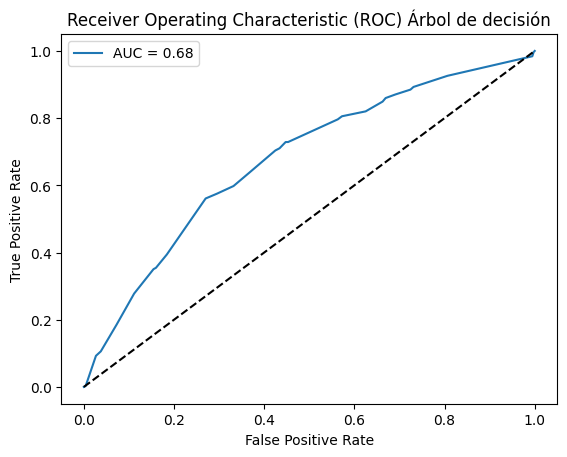

Accuracy del modelo de regresión logística:  0.616
F1-score del modelo de regresión logística:  0.6065573770491803


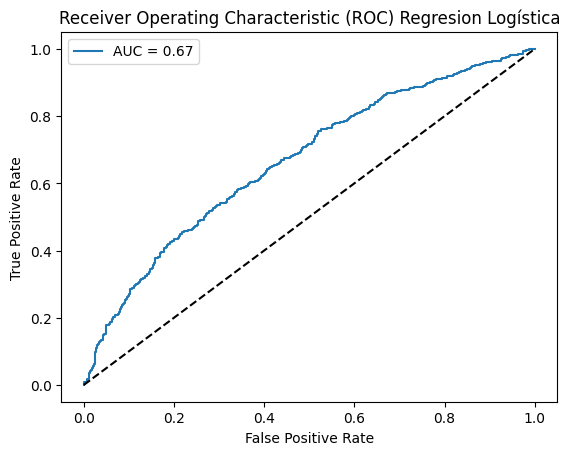

In [40]:
# Celda 6
# Se entrena un modelo de clasificación de arbol de decisión
from sklearn.tree import DecisionTreeClassifier
modelo_DTC = DecisionTreeClassifier(random_state=42, max_depth=5) # Se corrieron varios intentos cambiando el max_depth
modelo_DTC.fit(X_train, y_train)

# Se generan las predicciones para el conjunto de prueba y se evalua el modelo
from sklearn.metrics import accuracy_score, f1_score
y_pred_DTC = modelo_DTC.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_DTC)
f1 = f1_score(y_test, y_pred_DTC)
print("Accuracy del modelo de árbol: ", accuracy)
print("F1-score del modelo de árbol: ", f1)

# Se grafica AUC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
y_pred_proba = modelo_DTC.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='AUC = %.2f' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Árbol de decisión')
plt.legend(loc='best')
plt.show()

# Se entrena un modelo de regresion logistica
from sklearn.linear_model import LogisticRegression
modelo_log = LogisticRegression(max_iter=1000)
modelo_log.fit(X_train, y_train)

# Se generan las predicciones para el conjunto de prueba y se evalua el modelo
y_pred_log = modelo_log.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)
print("Accuracy del modelo de regresión logística: ", accuracy)
print("F1-score del modelo de regresión logística: ", f1)

# Se grafica AUC
y_pred_proba = modelo_log.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='AUC = %.2f' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Regresion Logística')
plt.legend(loc='best')
plt.show()

**Comentarios**
* El modelo de arbol obtiene mayor accuracy y mayor F1-score que el modelo de regresión logística
* Para el modelo de arbol se intenta calibrar usando el max_depth, encontrando el mayor accuracy con un valor de 5
* Se grafican las curvas ROC y se obtiene el AUC para los dos modelos confirmando un desempeño ligeramente mayor en el modelo de arbol

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [47]:
# Celda 7
# Creación de 300 muestras de bootstrap
n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 300 modelos con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

modelos = {}
for i in range(n_estimators):
    if i < 100:
        modelos[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=5, random_state=seeds[i])
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    elif i < 200:
        modelos[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i], min_samples_leaf=3)
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    else:
        modelos[i] = LogisticRegression(max_iter=1000)
        modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])


# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = modelos[i].predict(X_test)

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int64)

# Desempeño al hacer votación mayoritaria
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy del ensamblaje: ", accuracy)
print("F1-score del ensamblaje: ", f1)

Accuracy del ensamblaje:  0.64
F1-score del ensamblaje:  0.6296296296296297


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

Accuracy del ensamblaje con votación ponderada:  0.6366666666666667
F1-score del ensamblaje con votación ponderada:  0.6254295532646048


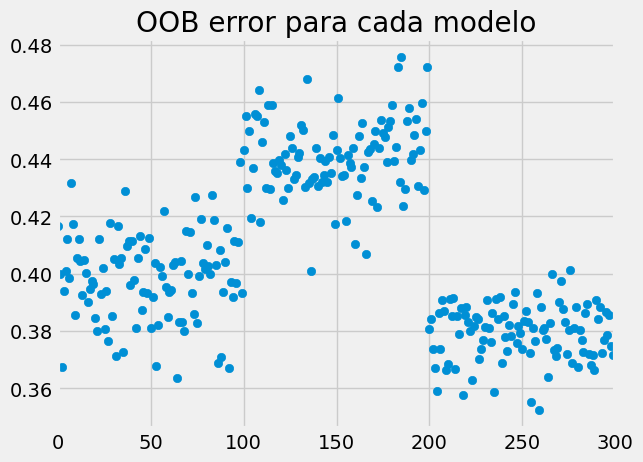

In [48]:
# Celda 8
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = modelos[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

# Visualización de OOB para cada árbol
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error para cada modelo')

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)

# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int64)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy del ensamblaje con votación ponderada: ", accuracy)
print("F1-score del ensamblaje con votación ponderada: ", f1)

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

**Resumen de resultados**
* Modelo de arbol (punto 6)
    * Accuracy del modelo de árbol:  0.64
    * F1-score del modelo de árbol:  0.6633416458852868
* Regresión logistica (punto 6)
    * Accuracy del modelo de regresión logística:  0.616
    * F1-score del modelo de regresión logística:  0.6065573770491803
* Ensamblaje con votación mayoritaria
    * Accuracy del ensamblaje:  0.64
    * F1-score del ensamblaje:  0.6296296296296297
* Ensamblaje con votación ponderada
    * Accuracy del ensamblaje con votación ponderada:  0.6366666666666667
    * F1-score del ensamblaje con votación ponderada:  0.6254295532646048

**Comentarios**
* En cuanto a accuracy el modelo de arbol y los ensamblajes tuvieron un desempeño similar
* En cuanto a F1-score el modelo de arbol tuvo el mayor valor, lo que resalta un buen equilibrio entre precision y recall
* La regresión logística obtuvo los rendimientos mas bajos de los 4 modelos, esto sugiere que la relación entre las variables no es lineal y es necesario algun tipo de transformación.
* Al parecer en este caso los ensamblajes no aportan una mejora significativa con respecto al modelo de arbol, sin embargo hay que destacar que mantienen un buen desempeño.